In [17]:
import numpy as np
import matplotlib.pyplot as plt

import torch   
from torch import nn
from torch.utils.data import DataLoader     # Puts dataset in iterable  
import torchvision 
from torchvision import datasets            # Stores samples/labels
from torchvision.transforms import ToTensor # Converts image to tensor (nparray)


In [18]:
# Download the training and testing datasets from MNIST
trainingData = datasets.FashionMNIST(
    root = "data",         # Which folder to download data to
    train = True,          # Just tells it to give you the training set
    download = True,       # Downloads to root directory  
    transform = ToTensor()
)


# Import Testing Data
testingData = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

In [19]:
# Create an iterable with our datasets to loop through more easily
batchSize = 64
trainDataloader = DataLoader(trainingData, batch_size=batchSize)
testDataloader = DataLoader(testingData, batch_size=batchSize)

labelMap = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

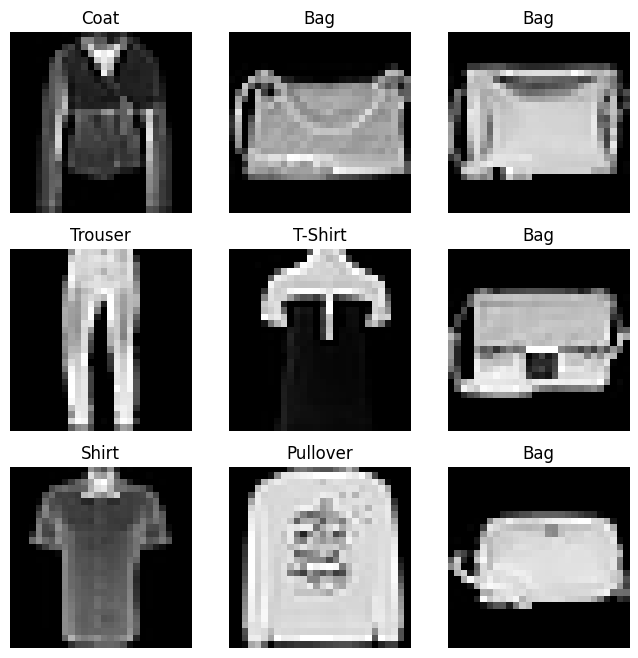

In [20]:
# Example of looping through datasets
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3

for i in range(1, cols*rows+1):
    # Cursed way of getting random int: generate random 1x1 array 
    # and take the first item
    sampleIndex = torch.randint(len(trainingData), size=(1,)).item()
    image, label = trainingData[sampleIndex] #Get out random image and its label
    
    figure.add_subplot(rows, cols, i)
    plt.title(labelMap[label])
    plt.axis("off") #Hides all axis decorations
    
    # 'Image' holds an array with 1 element: a single scaler image tensor
    # .squeeze() flattens all dimensions of size 1
    plt.imshow(image.squeeze(), cmap="gray")
    
    
plt.show()

In [33]:
# Getting the device that will be used for training
# cuda & mps both utilize GPU
# if neither are available, use CPU

device = (
    # CUDA is a an Nvidia GPU model that lets use do calculations on GPU
    "cuda" if torch.cuda.is_available()
    else
    
    # MPS is similar to Cuda
    "mps" if torch.backends.mps.is_available()
    else
    
    # Not optimal (training/testing speed reduced greatly)
    "cpu"
)

print(f"Using {device} device")

Using cuda device


In [44]:

# Create our own custom model that inherits from PyTorch.nn.Module
class NeuralNetwork(nn.Module):
    
    
    # Setup our model
    def __init__(self):
        super().__init__()
        
        # Uses the parent function that flattens 2d inputs into 1d
        self.flatten = nn.Flatten()
        
        # nn.Sequential allows for clear definition of what steps
        # are performed when using the model
        # 784 in --> 512 out
        # ReLU is our activation function
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), 
            nn.ReLU(),             
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    
    # Define how each computational step runs
    # Aka defines how values move through our layers
    def forward(self, x):
        x = self.flatten(x)
        outVals = self.linear_relu_stack(x)
        return outVals

    
#Create our model
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [50]:
# Cross Entropy Loss is the best loss function for image classification
lossFunc = nn.CrossEntropyLoss()

# Is what actually performances backpropogation and changes weights/biases
# lr = learning rate is how fast our parameters change each batch
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


def train(dataloader, model, lossFunc, optimizer):
    #When not in "training mode" the model will not do some calculations
    model.train()
    
    for batchNumber, (batchImages, batchLabels) in enumerate(dataloader):
        
        #Put data onto the same device that the model is currently on
        batchImages = batchImages.to(device)
        batchLabels = batchLabels.to(device)
        
        #Make predictions with current weights, then calculate loss against actual labels
        predictions = model(batchImages)
        loss = lossFunc(predictions, batchLabels)
        
        #Backpropogation
        loss.backward()  # Computes the negative gradient (direction to fastest decrease in loss function)
        optimizer.step() # Backpropogates the negative gradient through all layers
        optimizer.zero_grad() # Clears the gradient saved to optimizer (from loss.backward())
        
        #Print training loss every 100 batches
        """
        if batchNumber % 100 == 0:
            lossNum = loss.item() # Returns loss value as python float
            print(f"Loss: {lossNum}") 
        """

def test(dataloader, model, lossFunc):

    testSize = len(dataloader.dataset)
    numBatches = len(dataloader)
    model.eval() #Like model.train(), notifies all layer to go into eval mode
    
    avgLoss, correct = 0,0
    with torch.no_grad(): #Deactivates auto_gradient decent (no backprop)
        for batchImages, batchLabels in dataloader:

            #Send batch to device (GPU hopefully)
            batchImages = batchImages.to(device)
            batchLabels = batchLabels.to(device)

            predictions = model(batchImages)
            avgLoss += lossFunc(predictions, batchLabels).item() #.item() returns python float


            #Array of max values of all predictions w/ .argmax()
            #Parameter of arg max = reduces 1 dimension 
            # = 1D array of prediction tensor FOR EACH tensor in batch pred
            
            #Bool array of whether or not it matched w/ == batchLabels
            #Casted to float (0 = False, 1 = True) w/ .type(torch.float)
            #Summed up w/ .sum()
            #Turned into python float w/ .item()
            correct += (predictions.argmax(1) == batchLabels).type(torch.float).sum().item()

    avgLoss /= numBatches
    correct /= testSize
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {avgLoss:>8f} \n")
            



        
        
        
        
    
    

In [57]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainDataloader, model, lossFunc, optimizer)
    test(testDataloader, model, lossFunc)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.362176 

Done!


In [58]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth
